In [6]:
from scipy.linalg import svd
from sklearn.decomposition import TruncatedSVD
from IPython.html.widgets import interactive, fixed
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from ficlearn.feature_extraction.text import BnsTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from itertools import product
from sklearn import svm
from sklearn import cross_validation
from sklearn import metrics
from ficlearn.metrics import crossValidationScores
import codecs as cs
from nltk.corpus import stopwords
import string
import pandas as pd
import numpy as np
import nltk
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import MultinomialNB

from ggplot import *

from stop_words import get_stop_words

C:\Users\Therese\Anaconda3\envs\py36\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
C:\Users\Therese\Anaconda3\envs\py36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Therese\Anaconda3\envs\py36\lib\site-packages\ggplot\utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
C:\Users\Therese

In [7]:
def read_data():
    #Out: Y - Labels for all data points in data set, X - vectoized texts for each data points in the data set
    #     vocab - Vocuabulary of all words in the corpus
    #Effect: Reads in file of all listings in sweden to create a larger vocabulary. Reads in listings limited to the stockholm region.
    #        Preprocess the data frames. Creating labels for each datapoint.
    
    vocab = pd.read_json('output_new.json')
    df = pd.read_json('sthlm_format.json')
    print('Processing data....')
    preprocessing(vocab)
    preprocessing(df)
    Y = sort_to_categories(df)['categories']
    X = df['tokens']
    
    return X,Y, vocab, df

In [8]:
def preprocessing(df):
    #In: Dataframe that should be processed
    #Out: Tokenized dataframe. 
    #Effect: Removal of stopwords (Swedish most common words), non-letters, åäö is replaces with aa, ae, oe.
    
    stop = stopwords.words('swedish') + list(string.punctuation.encode('utf-8')) + ['gt', 'lt', 'amp', 'quot', 'align', '**', '***', '--', '//', '://', '),', ').']
    for i, s in enumerate(stop):
        stop[i] = str(s).replace(u'\xe5', 'aa').replace(u'\xe4', 'ae').replace(u'\xf6', 'oe')
    result = []
    for i, row in df.iterrows():
        sent = []
        doc = row['description']
        for word in nltk.wordpunct_tokenize(doc.lower()):
            if word not in stop and not is_int(word):
                sent.append(word)
        sent = ' '.join(sent)
        result.append(sent)
    df['tokens'] = result

In [13]:
def sort_to_categories(df, lower=2500000, higher=4000000):

    #In: dataframe with all data points, lower and higher decision bounderies
    #Out: Dataframe with all data points sorted into respective category
    #Effect: Sorting data points into three categories, boundery determine by inout parameters lower and higher.
    
    price_list = df['price'].tolist()
    
    max_price = df['price'].max()
    min_price = df['price'].min()
    mean_price = df['price'].mean()
    
    categories = []
    
    for i, each in enumerate(price_list):
        if each < lower:
            categories.append(0)

        
        elif each > higher:
            categories.append(2)
            
        else:
            categories.append(1)
    
    column_values = pd.Series(categories)
    df.insert(loc=0, column='categories', value=column_values)
    
    return df

In [10]:
def is_int(s):
    #In: token
    #Effect: Check if token is integer, if so return True. If not return False.
    
    try: 
        int(s)
        return True
    except ValueError:
        return False

In [11]:
def tfid_calc(X, n = 1):
    #In: Vocabulary of words in corpus, train and test data set and which n-gram model.
    #Out: Vectorized form of train and test data set
    #Effect: Vectorize text from the train and test sets
    
    tf = TfidfVectorizer(ngram_range=(n,n), min_df = 10).fit(X)
    X_tfidf = tf.fit_transform(X)
    
    return X_tfidf


# Get data

In [14]:
 X,Y,vocab,df = read_data()

Processing data....


### For visualization of distribution of category samples

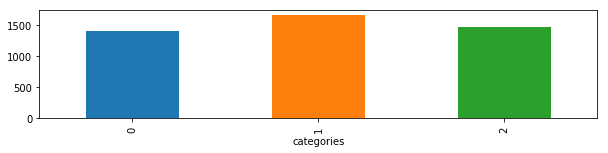

In [15]:
import matplotlib.pyplot as plt
ax = df.groupby('categories').size().plot(kind='bar', figsize=(10,2))

plt.show()

### Some play with the number of features, preserved Variance. 

To see how the number of features effects the variance. The orginal nr features is about 2500.

Variance preserved by first 1000 components == 87.07%


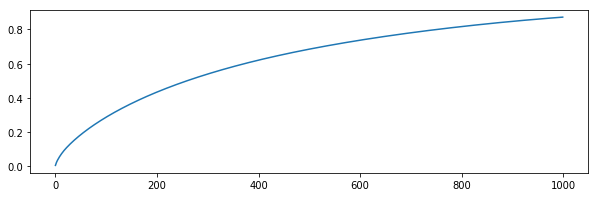

In [16]:
X = df['tokens']
X_tfidf = tfid_calc(X)

ncomps = 1000
svd = TruncatedSVD(n_components=ncomps)
svd_fit = svd.fit(X_tfidf)
Y = svd.fit_transform(X_tfidf) 
ax = pd.Series(svd_fit.explained_variance_ratio_.cumsum()).plot(kind='line', figsize=(10,3))
print('Variance preserved by first 1000 components == {:.2%}'.format(
        svd_fit.explained_variance_ratio_.cumsum()[-1]))

plt.show()

### Visualization of data 2D

To visulize the category distribution in a 2D space.

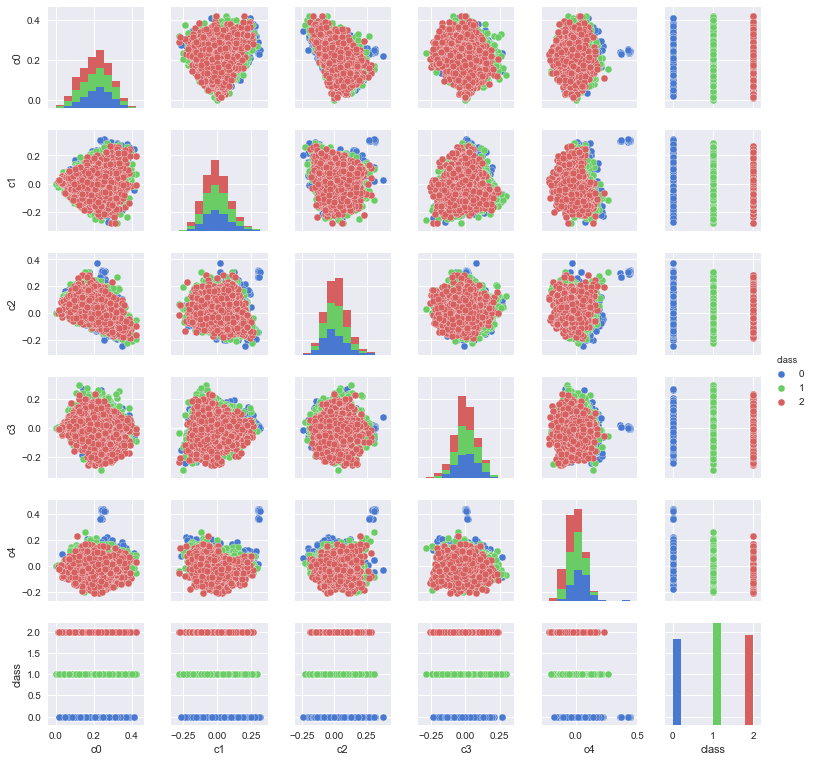

In [18]:
new_X = pd.DataFrame(Y, columns=['c{}'.format(c) for c in range(ncomps)])


sns.set(style="darkgrid", palette="muted")


plotdims = 5
ploteorows = 1
svdcols = [c for c in new_X.columns if c[0] == 'c']
dfsvdplot = new_X[svdcols].iloc[:,:plotdims]
dfsvdplot['class'] = df['categories']
ax = sns.pairplot(dfsvdplot.iloc[::ploteorows,:], hue='class', size=1.8)

plt.show()

### Vizualisation 3D

To visualize the category distribution in a 3d-space. Three components are used

In [19]:
def plot_3d_scatter(A, elevation=30, azimuth=120):
    """ Create 3D scatterplot """
    
    maxpts=1000
    fig = plt.figure(1, figsize=(9, 9))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=elevation, azim=azimuth)
    ax.set_xlabel('component 0')
    ax.set_ylabel('component 1')
    ax.set_zlabel('component 2')

    # plot subset of points
    rndpts = np.sort(np.random.choice(A.shape[0], min(maxpts,A.shape[0]), replace=False))
    coloridx = np.unique(A.iloc[rndpts]['categories'], return_inverse=True)
    colors = coloridx[1] / len(coloridx[0])   
    
    sp = ax.scatter(A.iloc[rndpts,0], A.iloc[rndpts,1], A.iloc[rndpts,2]
               ,c=colors, cmap="jet", marker='o', alpha=0.6
               ,s=50, linewidths=0.8, edgecolor='#BBBBBB')

    plt.show()

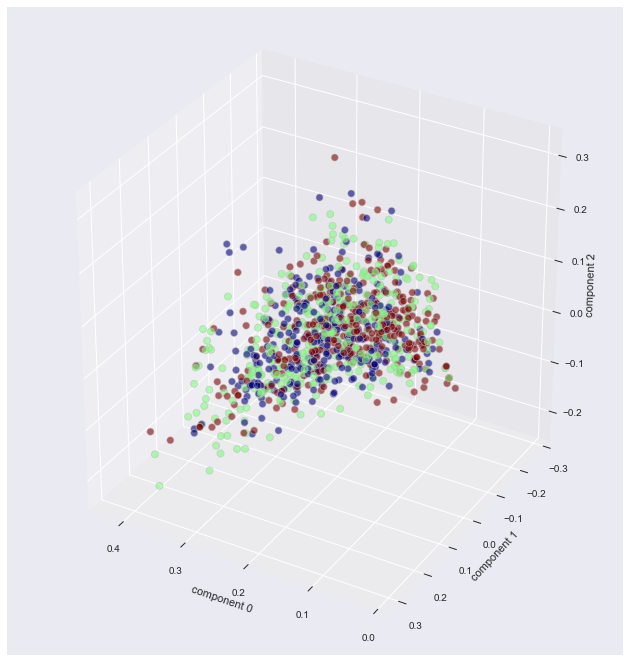

In [21]:
plotdims = 1000

svdcols = [c for c in new_X.columns if c[0] == 'c']
dfsvd = new_X[svdcols].iloc[:,:plotdims]
dfsvd['categories'] = df['categories']
interactive(plot_3d_scatter, A=fixed(dfsvd), elevation=30, azimuth=120)

### Explained variation per principal component

In [22]:
new_X.shape, df['categories'].shape

dfsvd['class'] = df['categories']
df = dfsvd

'Size of the dataframe: {}'.format(df.shape)

rndperm = np.random.permutation(df.shape[0])

from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[svdcols].values)

df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]

'Explained variation per principal component: {}'.format(pca.explained_variance_ratio_)

'Explained variation per principal component: [ 0.01251586  0.01063749  0.00803604]'

###  'Explained variation per principal component (PCA)

In [23]:
chart = ggplot( df.loc[rndperm[:3000],:], aes(x='pca-one', y='pca-two', color='class') ) \
        + geom_point(size=25,alpha=0.8) \
        + ggtitle("First and Second Principal Components colored by digit")
chart

pca_50 = PCA(n_components=600)
pca_result_50 = pca_50.fit_transform(df[svdcols].values)

'Explained variation per principal component (PCA): {}'.format(np.sum(pca_50.explained_variance_ratio_))

'Explained variation per principal component (PCA): 0.8401958204445429'